In [ ]:
from __future__ import division
import datetime
import matplotlib.pyplot as plt
import cPickle as pickle
import numpy as np
import v2gsim
import pandas as pd
import v2gsim.battery_degradation.CapacityLoss

data_name = 'iteration1_correct'
data_name2='iteration2_correct_testCap'
# ### Require gurobi or CPLEX #####
# Create a project and initialize it with some itineraries
project = v2gsim.model.Project(timestep=1)
project = v2gsim.itinerary.from_excel(project, '../data/NHTS/California.xlsx')
project = v2gsim.itinerary.copy_append(project, nb_of_days_to_add=2)
##==========================Degeadation===============================
# Create a detailed power train model
car_model = v2gsim.driving.detailed.init_model.load_powertrain('../v2gsim/driving/detailed/data.xlsx')

# This function from the itinerary module return all the vehicles that
# start and end their day at the same location (e.g. home)
project.vehicles = v2gsim.itinerary.get_cycling_itineraries(project)

# Reduce the number of vehicles
project.vehicles = project.vehicles[0:100]

# Create some new charging infrastructures, append those new
# infrastructures to the project list of infrastructures
charging_stations = []
charging_stations.append(
    v2gsim.model.ChargingStation(name='L2', maximum_power=7200, minimum_power=0))
charging_stations.append(
    v2gsim.model.ChargingStation(name='L1_V1G', maximum_power=1400, minimum_power=0, post_simulation=True))
charging_stations.append(
    v2gsim.model.ChargingStation(name='L2_V2G', maximum_power=7200, minimum_power=-7200, post_simulation=True))
project.charging_stations.extend(charging_stations)

 #Create a data frame with the new infrastructures mix and
# apply this mix at all the locations
df = pd.DataFrame(index=['L2', 'L1_V1G', 'L2_V2G'],
                      data={'charging_station': charging_stations,
                            'probability': [0.0, 0.4, 0.6]})
for location in project.locations:
    if location.category in ['Work', 'Home']:
        location.available_charging_station = df.copy()

# Initiate SOC and charging infrastructures
v2gsim.core.initialize_SOC(project, nb_iteration=2)

# Assign a basic result function to save power demand
for vehicle in project.vehicles:
    vehicle.result_function = v2gsim.post_simulation.netload_optimization.save_vehicle_state_for_optimization
##==============    Add car model
    vehicle.car_model = car_model
    vehicle.result_function = v2gsim.result.save_detailed_vehicle_state

##================   Assign drivecycles to all driving activities
v2gsim.driving.drivecycle.generator.assign_EPA_cycle(project)


# Launch the simulation
v2gsim.core.run(project, date_from=project.date + datetime.timedelta(days=1),
                date_to=project.date + datetime.timedelta(days=2),
                reset_charging_station=False)


# input climate data
radiation = open('../data/climate/radm.txt', 'r+')
r = radiation.readlines()
radH = []
for i in range(len(r)):
	for k in range(0,3600):
		radH.append(float(r[i]))

amtem = open('../data/climate/temm.txt', 'r+')
t = amtem.readlines()
ambientT = []
for i in range(len(t)):
	for k in range(0,3600):
		ambientT.append(float(t[i]))

# Call battery degradation calculation function
v2gsim.battery_degradation.CapacityLoss.bd(project.vehicles, radH, ambientT, days=1)


# Look at the results
total_power_demand = v2gsim.post_simulation.result.total_power_demand(project)


In [32]:
import pandas as pd
def init_load(day,HorizonHours):
    df_load = pd.read_csv('../data/netload/CAISO2019Load.csv',header=0)[24*day:(24*day+HorizonHours)]
    return df_load
def init_gen():
    df_gen = pd.read_csv('../data/generator/Generator.csv',header=0)
    return df_gen

def init_solar(day,HorizonHours):
    df_solar_cap=pd.read_csv('../data/generator/SolarCap.csv',header=0)[24*day:(24*day+HorizonHours)]
    df_solar_cons=pd.read_csv('../data/generator/SolarConstraint.csv',header=0)
    return  df_solar_cap,df_solar_cons

def init_wind(day,HorizonHours):
    df_wind_cap=pd.read_csv('../data/generator/WindCap.csv',header=0)[24*day:(24*day+HorizonHours)]
    df_wind_cons=pd.read_csv('../data/generator/WindConstraint.csv',header=0)
    return df_wind_cap,df_wind_cons

def v2gResultConversion(myresult):
    N = 6# from 10mins to 1 hour
    myresult=myresult.groupby(myresult.index // N).sum()/6/1000000# from the unit of W to MW
    myresult=myresult.rename(columns={'EnergyDemand':'netload','EnergyGeneration':'gen_capacity_veh','Regup':'regup_capacity_veh','Regdown':'regdown_capacity_veh'})
    return myresult

def init_veh(myresult):
    veh=pd.concat([myresult,myresult],axis=0)
    veh.index=range(veh.shape[0])
    return veh

day = 0
HorizonHours=48
df_load=init_load(day,HorizonHours)
df_load=init_load(day,HorizonHours)
df_gen=init_gen()
df_solar_cap,df_solar_cons=init_solar(day,HorizonHours)
df_wind_cap,df_wind_cons=init_wind(day,HorizonHours)

myresult=v2gResultConversion(pd.read_csv('../data/vehicle/VehiclesCap_V2G_iteration1_version3_regupregdown120.csv',header=0))     
veh=init_veh(myresult)
df_load['netload']= veh['netload']+df_load['netload']
# df_veh_cap=veh[['gen_capacity_veh'	,'regup_capacity_veh',	'regdown_capacity_veh']]
df_load

,Unnamed: 0,netload
0,2019-01-01 00:00,73502.00000
1,2019-01-01 01:00,71488.00000
2,2019-01-01 02:00,70058.00000
3,2019-01-01 03:00,69474.00000
4,2019-01-01 04:00,70032.00000
5,2019-01-01 05:00,71811.00110
6,2019-01-01 06:00,74224.00000
7,2019-01-01 07:00,74745.00264
8,2019-01-01 08:00,73903.00734
9,2019-01-01 09:00,72840.00792


In [9]:
df_gen

,name,maxcap,mincap,opcost,minup,ramp,st_cost,var_om,fix_om,regcost
0,10034_G_GEN1,85.0,85.0,30.926317,0,85.0,0,3.60,13170,3.092632
1,10034_G_GEN2,30.0,30.0,30.947589,0,30.0,0,3.60,13170,3.094759
2,10128_G_GEN1,0.2,0.2,0.041104,0,0.2,0,0.00,14130,9999.000000
3,10128_G_GEN2,0.2,0.2,0.012510,0,0.2,0,0.00,14130,9999.000000
4,10139_G_GEN1,5.9,5.9,0.033753,0,5.9,0,0.00,14130,9999.000000
5,10139_G_GEN2,5.9,5.9,0.024846,0,5.9,0,0.00,14130,9999.000000
6,10156_G_GEN2,6.0,6.0,31.476102,0,6.0,0,3.60,13170,3.147610
7,10156_G_GEN4,45.0,45.0,31.519860,0,45.0,0,3.60,13170,3.151986
8,10162_G_WWHI,1.3,1.3,0.010268,0,1.3,0,0.00,14130,9999.000000
9,10175_G_0799,2.0,2.0,261.466279,0,2.0,0,15.45,7340,9999.000000


In [39]:
def init_load(day,HorizonHours):
    df_load = pd.read_csv('../data/netload/CAISO2019Load.csv',header=0)[24*day:(24*day+HorizonHours)]
    return df_load
HorizonHours=48
myresult=v2gResultConversion(pd.read_csv('../data/vehicle/VehiclesCap_V2G_iteration1_version3_regupregdown120.csv',header=0))     
veh=init_veh(myresult)

for i in range(4):
    df_load=init_load(i,HorizonHours)
    df_load.index=range(48)
    df_load['netload']= veh['netload']+df_load['netload']
    print(df_load)

Unnamed: 0      netload
0   2019-01-01 00:00  73502.00000
1   2019-01-01 01:00  71488.00000
2   2019-01-01 02:00  70058.00000
3   2019-01-01 03:00  69474.00000
4   2019-01-01 04:00  70032.00000
5   2019-01-01 05:00  71811.00110
6   2019-01-01 06:00  74224.00000
7   2019-01-01 07:00  74745.00264
8   2019-01-01 08:00  73903.00734
9   2019-01-01 09:00  72840.00792
10  2019-01-01 10:00  71506.01276
11  2019-01-01 11:00  69849.01864
12  2019-01-01 12:00  68410.00720
13  2019-01-01 13:00  68109.01304
14  2019-01-01 14:00  69356.01442
15  2019-01-01 15:00  72647.01136
16  2019-01-01 16:00  79788.01592
17  2019-01-01 17:00  88055.01558
18  2019-01-01 18:00  89302.01248
19  2019-01-01 19:00  88474.01008
20  2019-01-01 20:00  86872.00768
21  2019-01-01 21:00  83592.00288
22  2019-01-01 22:00  78811.00168
23  2019-01-01 23:00  74373.00000
24  2019-01-02 00:00  71625.00000
25  2019-01-02 01:00  69927.00000
26  2019-01-02 02:00  69302.00000
27  2019-01-02 03:00  70026.00000
28  2019-01-02 04:00  72

In [28]:
import datetime as dt

df_load=init_load(day,HorizonHours)
# df_load


# df_load['netload']= veh['netload']+df_load['netload']
# veh['netload']
df_load['netload']
# df_veh_cap=veh[['gen_capacity_veh'	,'regup_capacity_veh',	'regdown_capacity_veh']]


0     73502.00000
1     71488.00000
2     70058.00000
3     69474.00000
4     70032.00000
5     71811.00110
6     74224.00000
7     74745.00264
8     73903.00734
9     72840.00792
10    71506.01276
11    69849.01864
12    68410.00720
13    68109.01304
14    69356.01442
15    72647.01136
16    79788.01592
17    88055.01558
18    89302.01248
19    88474.01008
20    86872.00768
21    83592.00288
22    78811.00168
23    74373.00000
Name: netload, dtype: float64

In [30]:
df_load.index=range(24)
df_load

,Unnamed: 0,netload
0,2019-01-01 00:00,73502.00000
1,2019-01-01 01:00,71488.00000
2,2019-01-01 02:00,70058.00000
3,2019-01-01 03:00,69474.00000
4,2019-01-01 04:00,70032.00000
5,2019-01-01 05:00,71811.00110
6,2019-01-01 06:00,74224.00000
7,2019-01-01 07:00,74745.00264
8,2019-01-01 08:00,73903.00734
9,2019-01-01 09:00,72840.00792


In [10]:
def saveResult(vehCap,pr,myresult,versionName):
    vehCap.to_csv('../Result/'+versionName+'vehicleGeneration.csv',index=False)
    pr.to_csv('../Result/'+versionName+'price.csv',index=False)
    sns.lineplot(data=calculateRevenue(vehCap,pr,myresult),dashes=False).get_figure().savefig("../Figure/"+versionName+"Revenue.png")
    
def calculateRevenue(vehCap,pr,myresult):
    demandCost=np.asarray(myresult['netload']*pr['pr_e']).sum()
    generationRev=np.asarray(vehCap['gen_capacity_veh']*pr['pr_e']).sum()
    regupRev=np.asarray(vehCap['regup_capacity_veh']*pr['pr_fre_u']).sum()
    regdownRev=np.asarray(vehCap['regdown_capacity_veh']*pr['pr_fre_d']).sum()
    revenue=generationRev+regupRev+regdownRev-demandCost
    return revenue


pr=pd.read_csv('../data/price/priceiteration2_version3_regupregdown20.csv',header=0) 
vehCap=pd.read_csv('../data/vehicle/VehiclesCap_iteration2_version3_regupregdown20.csv',header=0) 
myresult=v2gResultConversion(pd.read_csv('../data/vehicle/VehiclesCap_V2G_iteration1_version3_regupregdown120.csv',header=0))     

myresult


,netload,gen_capacity_veh,regup_capacity_veh,regdown_capacity_veh
0,0.00000,0.327445,-2.425319e-18,0.014852
1,0.00000,0.339026,0.000000e+00,0.006235
2,0.00000,0.334953,0.000000e+00,0.014962
3,0.00000,0.000000,0.000000e+00,0.013942
4,0.00000,0.333244,0.000000e+00,0.334939
5,0.00110,0.289412,0.000000e+00,0.334133
6,0.00000,0.000000,0.000000e+00,0.055142
7,0.00264,0.236645,0.000000e+00,0.177810
8,0.00734,0.273080,0.000000e+00,0.276057
9,0.00792,0.232106,0.000000e+00,0.260704


In [13]:
# import sns 
import seaborn as sns
import numpy as np
versionName='test'
saveResult(vehCap,pr,myresult,versionName)# not sure what should be the shape of myresult


TypeError: object of type 'numpy.float64' has no len()

451.9827700431403

In [19]:
saveResult(vehCap[:24],pr[:24],myresult,versionName)

TypeError: object of type 'numpy.float64' has no len()

In [15]:
# def saveResult(vehCap,pr,myresult,versionName):
#     vehCap.to_csv('../Result/'+versionName+'vehicleGeneration.csv',index=False)
#     pr.to_csv('../Result/'+versionName+'price.csv',index=False)
#     sns.lineplot(data=calculateRevenue(vehCap,pr,myresult),dashes=False).get_figure().savefig("../Figure/"+versionName+"Revenue.png")
    
# def calculateRevenue(vehCap,pr,myresult):
demandCost=np.asarray(myresult['netload']*pr['pr_e']).sum()
print(demandCost)
generationRev=np.asarray(vehCap['gen_capacity_veh']*pr['pr_e']).sum()
regupRev=np.asarray(vehCap['regup_capacity_veh']*pr['pr_fre_u']).sum()
regdownRev=np.asarray(vehCap['regdown_capacity_veh']*pr['pr_fre_d']).sum()
revenue=generationRev+regupRev+regdownRev-demandCost


nan


In [16]:
myresult['netload']

0     0.00000
1     0.00000
2     0.00000
3     0.00000
4     0.00000
5     0.00110
6     0.00000
7     0.00264
8     0.00734
9     0.00792
10    0.01276
11    0.01864
12    0.00720
13    0.01304
14    0.01442
15    0.01136
16    0.01592
17    0.01558
18    0.01248
19    0.01008
20    0.00768
21    0.00288
22    0.00168
23    0.00000
Name: netload, dtype: float64

In [17]:
pr['pr_e']

0     31.974683
1     31.974683
2     31.974683
3     31.974683
4     31.974683
5     31.974683
6     31.974683
7     31.974683
8     31.974683
9     31.974683
10    31.974683
11    31.974683
12    31.974683
13    31.974683
14    31.974683
15    32.879681
16    35.342703
17    37.972821
18    38.000062
19    35.076102
20    35.076102
21    31.974683
22    31.974683
23    31.974683
24    31.974683
Name: pr_e, dtype: float64

In [ ]:
def epsilon1(pr2,vehCap2,myresult2,pr,vehCap,myresult):
    return calculateRevenue(vehCap2,pr2,myresult2)-calculateRevenue(vehCap,pr,myresult)

def epsilon2(vehCap2,vehCap):
    return (abs(vehCap2-vehCap)).sum().sum()

eps=epsilon1(pr2,vehCap2,myresult2,pr,vehCap,myresult)
eps2=epsilon2(vehCap2,vehCap)

In [1]:
from __future__ import division
from pyomo.opt import SolverFactory
from pyomo.core import Var
from pyomo.core import Param
from operator import itemgetter
import pandas as pd
from datetime import datetime
import os
import datetime as dt
import matplotlib.pyplot as plt
import cPickle as pickle
import numpy as np
import v2gsim
import matplotlib.pyplot as plt
import seaborn as sns

def init_load(day,HorizonHours):
    df_load = pd.read_csv('../data/netload/CAISO2019Load.csv',header=0)[24*day:(24*day+HorizonHours)]
    return df_load
    
def init_gen():
    df_gen = pd.read_csv('../data/generator/Generator.csv',header=0)
    return df_gen

def init_solar(day,HorizonHours):
    df_solar_cap=pd.read_csv('../data/generator/SolarCap.csv',header=0)[24*day:(24*day+HorizonHours)]
    df_solar_cons=pd.read_csv('../data/generator/SolarConstraint.csv',header=0)
    return  df_solar_cap,df_solar_cons

def init_wind(day,HorizonHours):
    df_wind_cap=pd.read_csv('../data/generator/WindCap.csv',header=0)[24*day:(24*day+HorizonHours)]
    df_wind_cons=pd.read_csv('../data/generator/WindConstraint.csv',header=0)
    return df_wind_cap,df_wind_cons

def v2gResultConversion(myresult,vehicleNumber):
    N = 6# from 10mins to 1 hour
    myresult=myresult.groupby(myresult.index // N).sum()/6/1000000*vehicleNumber/100# from the unit of W to MW, from 100 vehicles to actual number of vehicles
    myresult=myresult.rename(columns={'EnergyDemand':'netload','EnergyGeneration':'gen_capacity_veh','Regup':'regup_capacity_veh','Regdown':'regdown_capacity_veh'})
    return myresult

def init_veh(myresult):
    veh=pd.concat([myresult,myresult],axis=0)
    veh.index=range(veh.shape[0])
    return veh

def epsilon1(pr2,vehCap2,myresult2,pr,vehCap,myresult):
    return abs(calculateRevenue(vehCap2[:24],pr2[:24],myresult2)-calculateRevenue(vehCap[:24],pr[:24],myresult))

def epsilon2(vehCap2,vehCap):
    return (abs(vehCap2[['gen_capacity_veh','regup_capacity_veh','regdown_capacity_veh']]-vehCap[['gen_capacity_veh','regup_capacity_veh','regdown_capacity_veh']])).sum().sum()

def saveResult(vehCap,pr,myresult,versionName,day):
    vehCap.to_csv('../Result/'+str(day)+"_"+versionName+'vehicleGeneration.csv',index=False)
    pr.to_csv('../Result/'+str(day)+"_"+versionName+'price.csv',index=False)
    # sns.lineplot(data=calculateRevenue(vehCap,pr,myresult),dashes=False).get_figure().savefig("../Figure/"+versionName+"Revenue.png")
    
def calculateRevenue(vehCap,pr,myresult):
    demandCost=np.asarray(myresult['netload']*pr['pr_e']).sum()
    generationRev=np.asarray(vehCap['gen_capacity_veh']*pr['pr_e']).sum()
    regupRev=np.asarray(vehCap['regup_capacity_veh']*pr['pr_fre_u']).sum()
    regdownRev=np.asarray(vehCap['regdown_capacity_veh']*pr['pr_fre_d']).sum()
    revenue=generationRev+regupRev+regdownRev-demandCost
    return revenue


#run number
yr=2019
run_no = 1
batteryCost=8
renewablePercentage=0.7
vehicleNumber=1500000# 1.5 million ZEVs in California by 2025
days=365
daysRange=range(0,1)
MWtoW=1000000
# should have battery cost/ renewable portion/ vehicle numbers
versionName=str(yr)+'_'+str(run_no)+'_battery'+str(batteryCost)+'_renewable'+str(renewablePercentage)+ '_vehicleNum'+str(vehicleNumber)

SimDays = 2
SimHours = SimDays * 24
HorizonHours = 48  ##planning horizon (e.g., 24, 48, 72 hours etc.)
regup_margin = 0.064  ##minimum regulation up reserve as a percent of system demand, referenced from https://www.nrel.gov/docs/fy19osti/73590.pdf
regdown_margin = 0.072 ##minimum regulation down reserve as a percent of system demand from https://www.nrel.gov/docs/fy19osti/73590.pdf


###Segment C.2
from UCModel import model
from UCModel import writeDatFile
from UCModel import readSolutionResult

revenueTotal=[]

for day in daysRange: #range(days)
    print(day+1)
    pr=pd.read_csv('../data/price/priceiteration2_version3_regupregdown20.csv',header=0) 
    vehCap=pd.read_csv('../data/vehicle/VehiclesCap_iteration2_version3_regupregdown20.csv',header=0) 
    myresult=v2gResultConversion(pd.read_csv('../data/vehicle/VehiclesCap_V2G_iteration1_version3_regupregdown20.csv',header=0),vehicleNumber)     
    print(myresult)
    iterNumber=1
    eps=10 
    eps2=10

    while eps>2 or eps2>2:
        # ### Require gurobi or CPLEX #####
        # Create a project and initialize it with some itineraries
        project = v2gsim.model.Project()
        project = v2gsim.itinerary.from_excel(project, '../data/NHTS/California.xlsx')
        project = v2gsim.itinerary.copy_append(project, nb_of_days_to_add=2)

        # This function from the itinerary module return all the vehicles that
        # start and end their day at the same location (e.g. home)
        project.vehicles = v2gsim.itinerary.get_cycling_itineraries(project)

        # Reduce the number of vehicles
        project.vehicles = project.vehicles[0:100]

        # Create some new charging infrastructures, append those new
        # infrastructures to the project list of infrastructures
        charging_stations = []
        charging_stations.append(
            v2gsim.model.ChargingStation(name='L2', maximum_power=7200, minimum_power=0))
        charging_stations.append(
            v2gsim.model.ChargingStation(name='L1_V1G', maximum_power=1400, minimum_power=0, post_simulation=True))
        charging_stations.append(
            v2gsim.model.ChargingStation(name='L2_V2G', maximum_power=7200, minimum_power=-7200, post_simulation=True))
        project.charging_stations.extend(charging_stations)

        #Create a data frame with the new infrastructures mix and
        # apply this mix at all the locations
        df = pd.DataFrame(index=['L2', 'L1_V1G', 'L2_V2G'],
                            data={'charging_station': charging_stations,
                                    'probability': [0.0, 0.4, 0.6]})
        for location in project.locations:
            if location.category in ['Work', 'Home']:
                location.available_charging_station = df.copy()

        # Initiate SOC and charging infrastructures
        v2gsim.core.initialize_SOC(project, nb_iteration=2)

        # Assign a basic result function to save power demand
        for vehicle in project.vehicles:
            vehicle.result_function = v2gsim.post_simulation.netload_optimization.save_vehicle_state_for_optimization


        # Launch the simulation
        v2gsim.core.run(project, date_from=project.date + dt.timedelta(days=1),
                        date_to=project.date + dt.timedelta(days=2),
                        reset_charging_station=False)


        # Look at the results
        total_power_demand = v2gsim.post_simulation.result.total_power_demand(project)

        # Optimization
        myopti = v2gsim.post_simulation.netload_optimization.CentralOptimization(project, 10,
                                                                                project.date + dt.timedelta(days=1),
                                                                                project.date + dt.timedelta(days=2),
                                                                                minimum_SOC=0.1, maximum_SOC=0.95)

        # # Load the load data
        load=init_load(day,HorizonHours)[:25]
        #CAISO1819: netload in the unit of MW
        load['Unnamed: 0'] = [dt.datetime.strptime(x,"%Y-%m-%d %H:%M") for x in load['Unnamed: 0']]
        load=load.set_index(load['Unnamed: 0'])
        load=load.drop(columns='Unnamed: 0')

        vehCap_v2g=vehCap.set_index(load[:25].index)
        pr_v2g=pr[:25].set_index(load[:25].index)
        
        
        myresult2= myopti.solve(project, load * MWtoW,vehicleNumber, price=pr_v2g, vehCap=vehCap_v2g*MWtoW,iterNumber=iterNumber, batteryCost=batteryCost, peak_shaving='economic', SOC_margin=0.05)# convert unit from MW to W
        myresult2=v2gResultConversion(myresult2,vehicleNumber)  
        print(myresult2)   
        veh=init_veh(myresult2)
       
        #initialize load, generator capacity
        df_load=init_load(day,HorizonHours)
        df_gen=init_gen()
        df_solar_cap,df_solar_cons=init_solar(day,HorizonHours)
        df_wind_cap,df_wind_cons=init_wind(day,HorizonHours)
        # reindex
        df_solar_cap.index=range(48)
        df_wind_cap.index=range(48)
        df_load.index=range(48)

        df_load['netload']= veh['netload']+df_load['netload']
        df_veh_cap=veh[['gen_capacity_veh'	,'regup_capacity_veh',	'regdown_capacity_veh']]

        # If not feasible, add NGCC 500MWh
        for i in range(200):
            df_gen=df_gen.append({'name':'AddedNGCC'+str(i),'maxcap':500,'mincap':0,'opcost':28.374682864574172,'minup':0.0,'ramp':500,'st_cost':0.0,'var_om':3.5999999999999996,'fix_om':13170.0,'regcost':2.837468286457417},ignore_index=True)
            
        # print(df_gen['maxcap'].sum())
        writeDatFile(df_gen,df_solar_cap,df_solar_cons,df_wind_cap,df_wind_cons,df_veh_cap,df_load,SimDays,SimHours,HorizonHours,regup_margin,regdown_margin,versionName,batteryCost)
        # print(df_veh_cap)
        ###Create instand and solve 
        instance = model.create_instance(versionName+'.dat')
        opt = SolverFactory("gurobi") ##SolverFactory("cplex")
        # opt.options["threads"] = 1
        H = instance.HorizonHours
        K=range(1,H+1)
     

        pr2,vehCap2=readSolutionResult(opt,instance,K,veh,df_gen,df_solar_cons,df_wind_cons,batteryCost)

        
        eps=epsilon1(pr2,vehCap2,myresult2,pr,vehCap,myresult)
        eps2=epsilon2(vehCap2,vehCap)
        
        vehCap=vehCap2
        pr=pr2
        myresult=myresult2
        iterNumber+=1
        # print(eps)
        # print(eps2)    
    saveResult(vehCap[:24],pr[:24],myresult,versionName,day)
    revenueTotal.append(calculateRevenue(vehCap[:24],pr[:24],myresult))
    print(day+1)
    # print(eps)
    # print(eps2)    
    print(revenueTotal)
    pd.DataFrame(data=revenueTotal).to_csv('../Result/'+str(day)+"_"+versionName+'Revenue.csv',index=False)


1
       netload  gen_capacity_veh  regup_capacity_veh  regdown_capacity_veh
0     0.000000       5544.000000               445.0           5918.000000
1     0.000000       5544.000000               472.0           5890.918734
2     0.000000       5544.000000               441.5           5921.500000
3    22.968031       5373.809016               439.5           5923.500000
4     0.000000       5544.000000               488.5           5853.500000
5     3.600000       5445.000000               393.5           5835.600000
6     7.200000       5293.924000               362.0           5819.200000
7    39.600000       5527.500000               353.2           5812.400000
8   108.600000       5643.000000               395.3           5954.800000
9   122.400000       5527.500000               304.3           5888.100000
10  165.600000       5230.500000               233.1           5712.500000
11  198.000000       4917.000000               238.1           5436.900000
12  169.326000       42

In [8]:
# from UC to V2G, buried in V2G, scale capacity and load smaller
# from v2g to UC, sclae up capacity, buried in Conversion Function
# *vehicleNumber/100
myresult2= myopti.solve(project, load * MWtoW,vehicleNumber, price=pr_v2g, vehCap=vehCap_v2g*MWtoW,iterNumber=iterNumber, batteryCost=batteryCost, peak_shaving='economic', SOC_margin=0.05)# convert unit from MW to W
myresult2

There is 95 vehicle participating in the optimization (95.0%)
There is 5 unfeasible vehicle.

Solver script file: '/var/folders/13/q5lg8m4538g2tfwj9r_zphbc0000gn/T/tmpcI3KVi.gurobi.script'
Solver log file: '/var/folders/13/q5lg8m4538g2tfwj9r_zphbc0000gn/T/tmpAZUAsm.gurobi.log'
Solver solution file: '/var/folders/13/q5lg8m4538g2tfwj9r_zphbc0000gn/T/tmpirnXh7.gurobi.txt'
Solver problem files: ('/var/folders/13/q5lg8m4538g2tfwj9r_zphbc0000gn/T/tmpIScTQ3.pyomo.lp',)
    model=unknown;
        message from solver=Problem proven to be infeasible or unbounded.
The optimization duration was 1.6163771828 minutes



,EnergyDemand,EnergyGeneration,Regup,Regdown
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,0,0,0
9,0,0,0,0


In [5]:
def v2gResultConversion(myresult,vehicleNumber):
    N = 6# from 10mins to 1 hour
    myresult=myresult.groupby(myresult.index // N).sum()/6/1000000*vehicleNumber/100# from the unit of W to MW, from 100 vehicles to actual number of vehicles
    myresult=myresult.rename(columns={'EnergyDemand':'netload','EnergyGeneration':'gen_capacity_veh','Regup':'regup_capacity_veh','Regdown':'regdown_capacity_veh'})
    return myresult

myresult=v2gResultConversion(pd.read_csv('../data/vehicle/VehiclesCap_V2G_iteration1_version3_regupregdown20.csv',header=0),vehicleNumber) 
myresult

,netload,gen_capacity_veh,regup_capacity_veh,regdown_capacity_veh
0,0.000000,5544.000000,445.0,5918.000000
1,0.000000,5544.000000,472.0,5890.918734
2,0.000000,5544.000000,441.5,5921.500000
3,22.968031,5373.809016,439.5,5923.500000
4,0.000000,5544.000000,488.5,5853.500000
5,3.600000,5445.000000,393.5,5835.600000
6,7.200000,5293.924000,362.0,5819.200000
7,39.600000,5527.500000,353.2,5812.400000
8,108.600000,5643.000000,395.3,5954.800000
9,122.400000,5527.500000,304.3,5888.100000


In [53]:
def epsilon1(pr2,vehCap2,myresult2,pr,vehCap,myresult):
    return abs(calculateRevenue(vehCap2[:24],pr2[:24],myresult2)-calculateRevenue(vehCap[:24],pr[:24],myresult))

def epsilon2(vehCap2,vehCap):
    return (abs(vehCap2[['gen_capacity_veh','regup_capacity_veh','regdown_capacity_veh']]-vehCap[['gen_capacity_veh','regup_capacity_veh','regdown_capacity_veh']])).sum().sum()


def saveResult(vehCap,pr,myresult,versionName,day):
    vehCap.to_csv('../Result/'+str(day)+"_"+versionName+'vehicleGeneration.csv',index=False)
    pr.to_csv('../Result/'+str(day)+"_"+versionName+'price.csv',index=False)
    # sns.lineplot(data=calculateRevenue(vehCap,pr,myresult),dashes=False).get_figure().savefig("../Figure/"+versionName+"Revenue.png")
    
def calculateRevenue(vehCap,pr,myresult):
    demandCost=np.asarray(myresult['netload']*pr['pr_e']).sum()
    generationRev=np.asarray(vehCap['gen_capacity_veh']*pr['pr_e']).sum()
    regupRev=np.asarray(vehCap['regup_capacity_veh']*pr['pr_fre_u']).sum()
    regdownRev=np.asarray(vehCap['regdown_capacity_veh']*pr['pr_fre_d']).sum()
    revenue=generationRev+regupRev+regdownRev-demandCost
    return revenue

nan

In [22]:
# calculateRevenue(vehCap2[:24],pr2[:24],myresult2) #okay
calculateRevenue(vehCap2[:24],pr2[:24],myresult2)

321.8750205867162

In [31]:
vehCap=vehCap2
pr=pr2
myresult=myresult2
calculateRevenue(vehCap[:24],pr2[:24],myresult)
# myresult

321.8750205867162

In [29]:
(abs(vehCap2[['gen_capacity_veh','regup_capacity_veh','regdown_capacity_veh']]-vehCap[['gen_capacity_veh','regup_capacity_veh','regdown_capacity_veh']])).sum().sum()

0.0

In [30]:
vehCap2==vehCap

ValueError: Can only compare identically-labeled DataFrame objects

In [56]:
eps=epsilon1(pr2,vehCap2,myresult2,pr,vehCap,myresult)
eps2=epsilon2(vehCap2,vehCap)

# vehCap=vehCap2
# pr=pr2
# myresult=myresult2
# iterNumber+=1
# print(eps)
# print(eps2)    
# print(revenueTotal)
saveResult(vehCap[:24],pr[:24],myresult,versionName,day)
# revenueTotal.append(calculateRevenue(vehCap[:24],pr[:24],myresult))

nan

In [63]:
print()

0
0  402.246812


In [61]:
revenueTotal

[]

1
/Users/meiyewang/opt/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
/Users/meiyewang/opt/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/Users/meiyewang/opt/anaconda3/envs/py27/lib/python2.7/site-packages/v2gsim/core.py:198: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To r

NameError: name 'myopti' is not defined

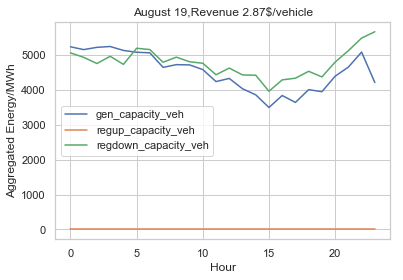

In [15]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


veh200=pd.read_csv('../Result/200_2019_1_battery8_renewable0.7_vehicleNum1500000vehicleGeneration.csv')
veh200=veh200[['gen_capacity_veh'	,'regup_capacity_veh',	'regdown_capacity_veh']]

sns.set()
sns.set_style("whitegrid")
sns.color_palette("Set2")

plt.title('August 19,Revenue 2.87$/vehicle')
plt.xlabel("Hour")
plt.ylabel("Aggregated Energy/MWh")
sns.lineplot(data=veh200,dashes=False).get_figure().savefig("../Figure/501Project/Aug19.png")
plt.show()


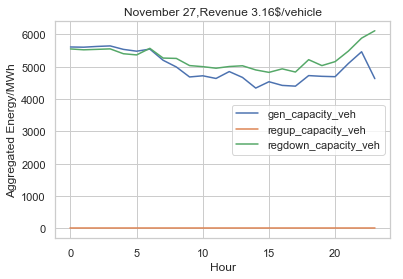

In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

veh300=pd.read_csv('../Result/300_2019_1_battery8_renewable0.7_vehicleNum1500000vehicleGeneration.csv')[['gen_capacity_veh'	,'regup_capacity_veh',	'regdown_capacity_veh']]


sns.set()
sns.set_style("whitegrid")
sns.color_palette("Set2")
plt.title('November 27,Revenue 3.16$/vehicle')
plt.xlabel("Hour")
plt.ylabel("Aggregated Energy/MWh")
sns.lineplot(data=veh300,dashes=False).get_figure().savefig("../Figure/501Project/Nov27.png")
plt.show()


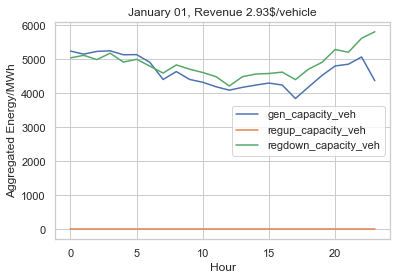

In [18]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

veh0=pd.read_csv('../Result/0_2019_1_battery8_renewable0.7_vehicleNum1500000vehicleGeneration.csv')[['gen_capacity_veh'	,'regup_capacity_veh',	'regdown_capacity_veh']]

sns.set()
sns.set_style("whitegrid")
sns.color_palette("Set2")
plt.title('January 01, Revenue 2.93$/vehicle')
plt.xlabel("Hour")
plt.ylabel("Aggregated Energy/MWh")
sns.lineplot(data=veh0,dashes=False).get_figure().savefig("../Figure/501Project/Jan01.png")
plt.show()

In [ ]:
May 11

In [7]:
4393532.891994468/1500000

2.929021927996312

In [9]:
4753426.22792077/1500000

3.1689508186138466

In [11]:
4311847.026029048/1500000


2.874564684019365

In [23]:
2.93-veh300.sum().sum()*8/1500000

1.6168506281326747